In [45]:
%matplotlib inline
from matplotlib import style
from datetime import date
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [46]:
import numpy as np
import pandas as pd

In [83]:
import datetime as dt
import seaborn as sns

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [49]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [50]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [51]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [72]:
# Calculate the date 1 year ago from the last data point in the database
year = dt.timedelta(days=365)
a_year_ago = dt.date(int(datefield[0]), int(datefield[1]), int(datefield[2])) - year
a_year_ago


datetime.date(2016, 8, 23)

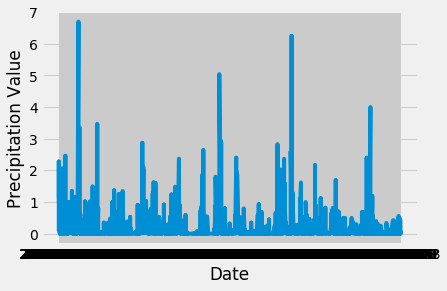

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date)).first()

#converts to string
datefieldlist = []
for field in max_date:
    datefieldlist.append(field)
    
#split list element into segements for input into date()
datefield = datefieldlist[0].split("-")


# Perform a query to retrieve the data and precipitation scores
scores = engine.execute("SELECT * FROM Measurement WHERE date > '2016-08-23'")
result = scores.fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result, columns=['line', 'Station', 'date', 'prcp', 'tobs'])
yearago = df
#save all data
scores = engine.execute("SELECT * FROM Measurement")
result = scores.fetchall()
alldata = pd.DataFrame(result, columns=['line', 'Station', 'date', 'prcp', 'tobs'])

df = df.drop('line', axis=1)
df = df.set_index('date')

# Sort the dataframe by date
df = df.sort_values('date')
df = df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
plt.xlabel('Date')
plt.ylabel('Precipitation Value')
plt.plot(df.index, df['prcp'])

# Save the Figure
plt.savefig("Precipitation_MM.png")

# Show the Figure
plt.show()


![precipitation](Images/precipitation.png)

In [69]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = df['prcp'].describe()
df2 = pd.DataFrame(summary)
df2 = df2.rename(columns={'prcp': 'Precipitation'})
df2

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [56]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [57]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [58]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
data = station_count[0][0]
# data
query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
query = query.filter(Measurement.station == data).all()
for q in query:
    print(q)

(54.0, 85.0, 71.66378066378067)


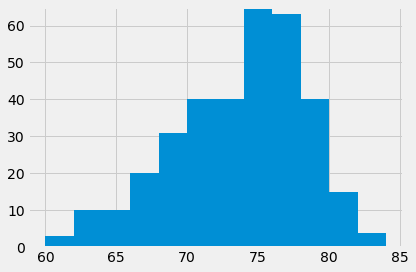

In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

last_12 = [q for q in session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == query[0]).filter(Measurement.date > '2016-08-23').all()]                                                                 
templist = []
for row in last_12:
    templist.append(row[2])
bins = np.arange(60, max(templist)+3, 2)
plt.ylim(0,65)
plt.hist(templist, bins)
plt.tight_layout()
# Save the Figure
plt.savefig("Histogram_MM.png")

# Show the Figure
plt.show();

![precipitation](Images/station-histogram.png)

In [60]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2015-08-23', '2016-08-23')
tempmin = temps[0][0]
tempavg = temps[0][1]
tempmax = temps[0][2]

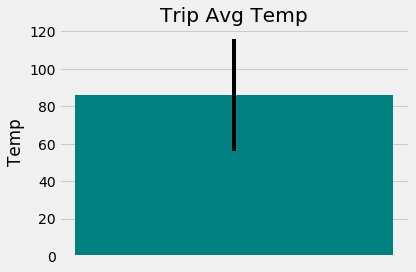

In [78]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(x=1, height=tempmax, yerr=tempmax-tempmin, width=0.1, color='teal')
plt.title("Trip Avg Temp")
plt.ylabel("Temp")
plt.xticks([0])
plt.tight_layout()
# save figure:
plt.savefig('Average_trip_temperature_MM.png')
plt.show()

In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()


[('USC00513117', 21.2716, -157.8168, 3.0, 3443.5800000001063),
 ('USC00518838', 21.2716, -157.8168, 3.0, 637.8299999999936),
 ('USC00519281', 21.2716, -157.8168, 3.0, 5297.7600000003895),
 ('USC00519523', 21.2716, -157.8168, 3.0, 2661.120000000018),
 ('USC00516128', 21.2716, -157.8168, 3.0, 9612.810000000345),
 ('USC00519397', 21.2716, -157.8168, 3.0, 1184.5799999999226),
 ('USC00511918', 21.2716, -157.8168, 3.0, 834.119999999968),
 ('USC00514830', 21.2716, -157.8168, 3.0, 2110.40999999993),
 ('USC00517948', 21.2716, -157.8168, 3.0, 390.95999999999873)]

## Optional Challenge Assignment

In [64]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [80]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_n = []
dn=0
dates = []
for day in range (1,24):
    if day < 10:
        dn = daily_normals(f"08-0{day}")
        daily_n.append(list(np.ravel(dn)))
        dates.append(f"2016-01-0{day}")
    else: 
        dn = daily_normals(f"08-{day}")
        daily_n.append(list(np.ravel(dn)))
        dates.append(f"2017-01-{day}")
                                     
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
                                    
daily_n_df = pd.DataFrame(list(daily_n), columns=['tmin','tavg','tmax'])
daily_n_df['dates'] = dates                                
daily_n_df = daily_n_df.set_index('dates')
daily_n_df.head(5)

,tmin,tavg,tmax
dates,,,
2016-01-01,67.0,75.540000,83.0
2016-01-02,68.0,75.603774,84.0
2016-01-03,70.0,76.611111,85.0
2016-01-04,69.0,76.711538,84.0
2016-01-05,69.0,76.148148,82.0


In [66]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


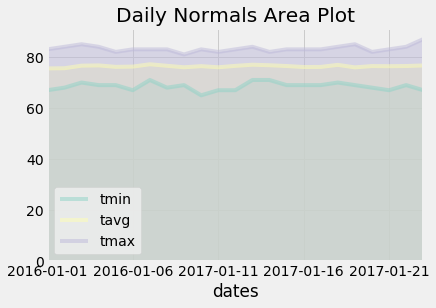

In [86]:
# Plot the daily normals as an area plot with `stacked=False`
pal = sns.color_palette("Set3")
daily_n_df.plot(kind='area', stacked=False, alpha=0.5,color=pal,
        title='Daily Normals Area Plot')
[ax.legend(('tmin','tavg','tmax'),
           loc='lower left') for ax in plt.gcf().axes]

# Save the Figure
plt.savefig("Daily_Normals_MM.png")


plt.show()